In [3]:
import random

import pennylane as qml
import torch
from data_utils import mnist_preparation
from typing import Optional, Dict, List, Any
from torch.utils.data import DataLoader, dataloader
from tqdm import tqdm
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [4]:
labels = [0,1,2,3]
# Download MNIST and prepare transforms
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
                                transforms.Resize((16, 16)),  # Resize to 16x16
                                transforms.ToTensor(),
                                #transforms.Lambda(lambda img: add_salt_and_pepper_noise(img, salt_prob=0.1, pepper_prob=0.1)),
                                transforms.Normalize((0.1307,), (0.3081,))  # Normalize
                             ]))
#train/vali/test 70/15/15 split, see data_utils.py for further details
train_dataloader, validation_dataloader, test_dataloader = mnist_preparation(dataset=mnist, labels = labels, train_test_ratio=0.7,batch_size=64, vali_test_ratio=0.5)

print("Images in the training set: ", len(train_dataloader.dataset), "\n Images in the validation set: ", len(validation_dataloader.dataset), "\n Images in the test set: ", len(test_dataloader.dataset))

Images in the training set:  17327 
 Images in the validation set:  3713 
 Images in the test set:  3714


In [6]:
"""import pickle
with open('/Users/jackvittori/Desktop/allenamento26sett/om/trhistory.pickle', 'rb') as file: 
    tr_history = pickle.load(file)
weights = tr_history['weights']"""

NameError: name 'weights' is not defined

In [7]:
import pickle
with open('/Users/jackvittori/Desktop/4layerokkkk/weight4layer.pickle', 'rb') as file: 
    weights = pickle.load(file)
weights

ParameterDict(
    (layer_0): Parameter containing: [torch.FloatTensor of size 8x3]
    (layer_1): Parameter containing: [torch.FloatTensor of size 8x3]
    (layer_2): Parameter containing: [torch.FloatTensor of size 8x3]
    (layer_3): Parameter containing: [torch.FloatTensor of size 8x3]
)

In [12]:
weights = {key: param.detach().numpy() for key, param in weights.items()}

In [29]:
mixed_device = qml.device('default.mixed', wires=8, shots = 1000)

def quantum_function(state: torch.Tensor = None):
    if state is not None:
        qml.QubitStateVector(state, wires=range(8))
    for i in range(4):
        for j in range(8):
            qml.RX(weights[f'layer_{i}'][j, 0], wires=j)
            qml.RY(weights[f'layer_{i}'][j, 1], wires=j)
            qml.RZ(weights[f'layer_{i}'][j, 2], wires=j)
        
        for j in range(8):
            qml.CNOT(wires=[j, (j + 1) % 8])
            qml.DepolarizingChannel(p=0.07, wires=(j + 1) % 8)
    return qml.probs()

mixed_qnode = qml.QNode(quantum_function, device=mixed_device, interface = 'numpy')

In [30]:
from pennylane import numpy as np
results = []
test_accuracy = []
for i, (img,targets) in tqdm(enumerate(test_dataloader.dataset)):
    if i ==2000:
        break
    """img = img.type(torch.float64)
    img = img / torch.linalg.norm(img).view(-1, 1)
    probs = mixed_qnode(img, shots = 1000)
    class_probabilities = torch.zeros(4, dtype=torch.float32)
    for idx in range(4):
    # Calculate the index range for each class
        start_idx = int(idx * (256 / 4))
        end_idx = int((idx + 1) * (256 / 4))
        class_probabilities[idx] = torch.sum(probs[start_idx:end_idx])
    print(torch.argmax(class_probabilities), targets)"""
    
    img = img.numpy().astype(np.float64)
    targets = targets.numpy()
    norm = np.linalg.norm(img)
    norm = norm.reshape(-1,1)
    img = img / norm
    probs = mixed_qnode(img, shots = 1000)
    class_probabilities = np.zeros(4, dtype=np.float32)
    for idx in range(4):
    # Calculate the index range for each class
        start_idx = int(idx * (256 / 4))
        end_idx = int((idx + 1) * (256 / 4))
        class_probabilities[idx] = np.sum(probs[start_idx:end_idx])
    results.append(np.argmax(class_probabilities)==targets)
    """
    data = data.type(torch.float64)
    data = data / torch.linalg.norm(data, dim = 1).view(-1, 1)
    output = mixed_qnode(data).type(torch.float32)
    probabilities = torch.zeros(output.shape[0], 4, dtype=torch.float32)
    for idx in range(4):
        # Calculate the index range for each class
        start_idx = int(idx * (256 / 4))
        end_idx = int((idx + 1) * (256 / 4))
        probabilities[:, idx] = torch.sum(torch.abs(output[:, start_idx:end_idx]) ** 2, dim=1)
        
    predictions = torch.argmax(probabilities, dim = 1)
    batch_accuracy = torch.sum(predictions == targets).item() / len(predictions)
    #print(batch_accuracy)
    test_accuracy.append(batch_accuracy)
    #predictions = torch.argmax(output, dim=1)
    #batch_accuracy = torch.sum(predictions == targets).item() / len(predictions)
    #print(batch_accuracy)"""
 
print("The accuracy over the test is ", sum(results)/len(results))    
#print("The accuracy over the test is ", sum(test_accuracy)/len(test_accuracy))

2000it [10:59,  3.03it/s]

The accuracy over the test is  0.627


In [ ]:
from pennylane import numpy as np
results = []
test_accuracy = []
for i, (img,targets) in tqdm(enumerate(test_dataloader.dataset)):
    #if i ==2000:
     #   break
    """img = img.type(torch.float64)
    img = img / torch.linalg.norm(img).view(-1, 1)
    probs = mixed_qnode(img, shots = 1000)
    class_probabilities = torch.zeros(4, dtype=torch.float32)
    for idx in range(4):
    # Calculate the index range for each class
        start_idx = int(idx * (256 / 4))
        end_idx = int((idx + 1) * (256 / 4))
        class_probabilities[idx] = torch.sum(probs[start_idx:end_idx])
    print(torch.argmax(class_probabilities), targets)"""
    
    img = img.numpy().astype(np.float64)
    targets = targets.numpy()
    norm = np.linalg.norm(img)
    norm = norm.reshape(-1,1)
    img = img / norm
    probs = mixed_qnode(img, shots = 1000)
    class_probabilities = np.zeros(4, dtype=np.float32)
    for idx in range(4):
    # Calculate the index range for each class
        start_idx = int(idx * (256 / 4))
        end_idx = int((idx + 1) * (256 / 4))
        class_probabilities[idx] = np.sum(probs[start_idx:end_idx])
    results.append(np.argmax(class_probabilities)==targets)
    """
    data = data.type(torch.float64)
    data = data / torch.linalg.norm(data, dim = 1).view(-1, 1)
    output = mixed_qnode(data).type(torch.float32)
    probabilities = torch.zeros(output.shape[0], 4, dtype=torch.float32)
    for idx in range(4):
        # Calculate the index range for each class
        start_idx = int(idx * (256 / 4))
        end_idx = int((idx + 1) * (256 / 4))
        probabilities[:, idx] = torch.sum(torch.abs(output[:, start_idx:end_idx]) ** 2, dim=1)
        
    predictions = torch.argmax(probabilities, dim = 1)
    batch_accuracy = torch.sum(predictions == targets).item() / len(predictions)
    #print(batch_accuracy)
    test_accuracy.append(batch_accuracy)
    #predictions = torch.argmax(output, dim=1)
    #batch_accuracy = torch.sum(predictions == targets).item() / len(predictions)
    #print(batch_accuracy)"""
 
print("The accuracy over the test is ", sum(results)/len(results))    
#print("The accuracy over the test is ", sum(test_accuracy)/len(test_accuracy))

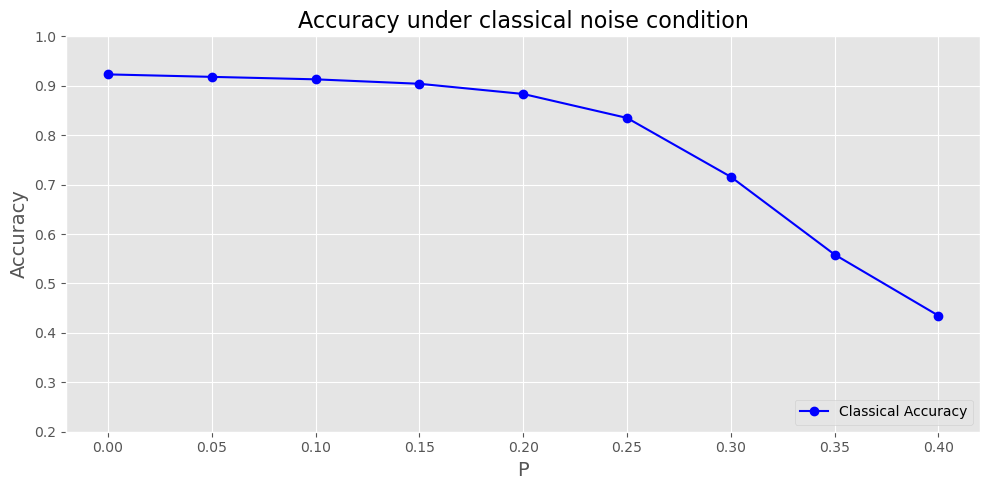

In [63]:
import matplotlib.pyplot as plt

# Dati
accuracy_class = [0.9230, 0.9180, 0.9130, 0.9040, 0.8834, 0.8349, 0.7157, 0.5584, 0.4348]
class_p = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

# Creazione grafico
plt.style.use('ggplot') 
fig, ax = plt.subplots(figsize=(10, 5))

# Titoli e etichette
ax.set_title('Accuracy under classical noise condition', fontsize=16)
ax.set_xlabel('P', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(0.2, 1)

# Tracciare i punti collegati
ax.plot(class_p, accuracy_class, marker='o', color='b', label='Classical Accuracy')

# Legenda
ax.legend(loc='lower right')

# Griglia e layout
ax.grid(True)
plt.tight_layout()

# Visualizzazione grafico
plt.show()
fig.savefig('/Users/jackvittori/Desktop/plots/noiseoriginale.png', dpi=300)

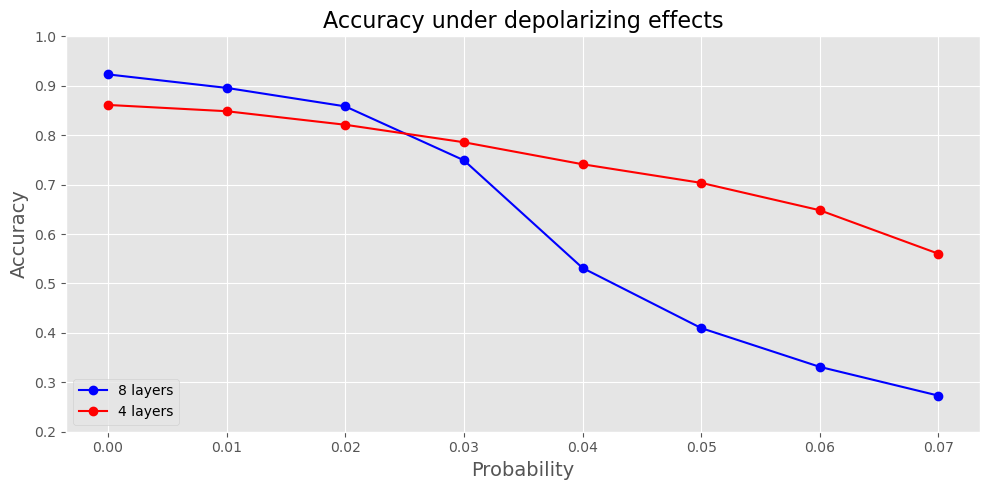

In [35]:
import matplotlib.pyplot as plt

# Dati
accuarcy_dep = [0.9230, 0.8957, 0.8583, 0.7492, 0.5314, 0.4097, 0.3312, 0.2730]
class_p = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]
accuracy_4 = [0.8612, 0.8485, 0.8211, 0.7857, 0.7412, 0.7035, 0.6481, 0.5601]

# Creazione grafico
plt.style.use('ggplot') 
fig, ax = plt.subplots(figsize=(10, 5))

# Titoli e etichette
ax.set_title('Accuracy under depolarizing effects', fontsize=16)
ax.set_xlabel('Probability', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(0.2, 1)

# Tracciare i punti collegati
ax.plot(class_p, accuarcy_dep, marker='o', color='b', label='8 layers')
ax.plot(class_p, accuracy_4, marker='o', color='r', label='4 layers')

# Legenda
ax.legend(loc='lower left')

# Griglia e layout
ax.grid(True)
plt.tight_layout()

# Visualizzazione grafico
plt.show()
fig.savefig('/Users/jackvittori/Desktop/plots/depnoiseoriginale.png', dpi=300)

In [ ]:
accuarcy_dep = [0.9230, 0.8957, 0.8583, 0.7492, 0.5314, 0.4097, 0.3112, 0.2730]